In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

# Data read
there're too much data to handle in the data set. So we randomly pick 1% of the data to do processing.

In [2]:
p = 0.01
data = pd.read_csv('data/2017_Green_Taxi_Trip_Data.csv', parse_dates=['lpep_pickup_datetime','lpep_dropoff_datetime'], infer_datetime_format=True, skiprows=lambda i: i>0 and random.random() > p)

In [3]:
data.sample(2)
#data

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type
1529,2,2017-01-05 19:54:08,2017-01-05 20:06:31,N,1,97,225,1,2.35,11.0,1.0,0.5,2.0,0.0,NaN,0.3,14.8,1,1
97606,2,2017-10-26 16:22:47,2017-10-26 16:51:20,N,1,26,257,3,2.89,18.5,1.0,0.5,0.0,0.0,NaN,0.3,20.3,1,1


# Average price per mile of different payment type by trip distance 
We don't know the affect of payment type on price. And we don't want to directly use total fare since it is dependant on trip distance. So we calculate price per mile. But also price per mile is also dependant on trip distance. Therefore we divide trip distance into 6 intervals. And for most of the charts following, we will calculate with these interval.
* [0, 4)
* [4, 8)
* [8, 12)
* [12, 16)
* [16, 20)
* [20, $\infty$)

From the result, we can see payments other than credit card or cash are not consistent. For the comparason between credit card and cash, there's no significant differences between them. 

In [4]:
cost_pay = pd.DataFrame(columns=['credit', 'cash', 'no_charge', 'dispute', 'unknown', 'voided']);
for i in range (0, 24, 4):
    if (i == 20):
        d_dis = data[(data['trip_distance'] >= i)]
    else:
        d_dis = data[(data['trip_distance'] >= i) & (data['trip_distance'] < (i+4))];
    d_cr = d_dis[d_dis['payment_type']==1];
    d_ca = d_dis[d_dis['payment_type']==2];
    d_nc = d_dis[d_dis['payment_type']==3];
    d_dp = d_dis[d_dis['payment_type']==4];
    d_uk = d_dis[d_dis['payment_type']==5];
    d_vd = d_dis[d_dis['payment_type']==6];
    av_cr = 0
    av_ca = 0
    av_nc = 0
    av_dp = 0
    av_uk = 0
    av_vd = 0
    if (d_cr.shape[0] > 0):
        av_cr =  d_cr['fare_amount'].sum()/d_cr['trip_distance'].sum()
    if (d_ca.shape[0] > 0):
        av_ca =  d_ca['fare_amount'].sum()/d_ca['trip_distance'].sum()
    if (d_nc.shape[0] > 0):
        av_nc =  d_nc['fare_amount'].sum()/d_nc['trip_distance'].sum()
    if (d_dp.shape[0] > 0):
        av_dp =  d_dp['fare_amount'].sum()/d_dp['trip_distance'].sum()
    if (d_uk.shape[0] > 0):
        av_uk =  d_uk['fare_amount'].sum()/d_uk['trip_distance'].sum()
    if (d_vd.shape[0] > 0):
        av_vd =  d_vd['fare_amount'].sum()/d_vd['trip_distance'].sum()
    #print(av_cr)
    #print(av_ca)
    #print(av_uk)
    df_add = pd.DataFrame({'credit': av_cr, 'cash': av_ca, 'no_charge': av_nc, 'dispute': av_dp, 'unknown': av_uk, 'voided': av_vd}, index=[i])
    #print(df_add)
    cost_pay = cost_pay.append(df_add)
cost_pay

/home/kaidong/Softwares/anaconda2/lib/python2.7/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


,cash,credit,dispute,no_charge,unknown,voided
0,5.390259,5.261453,4.613372,2.202397,6.666667,0
4,3.693161,3.775361,3.465201,3.430908,4.000000,0
8,3.269888,3.323046,3.375594,3.689474,0.000000,0
12,3.074860,3.173282,0.000000,1.365031,0.000000,0
16,3.043819,3.092092,0.000000,0.000000,0.000000,0
20,3.144036,3.116145,0.000000,2.889908,0.000000,0


Text(0,0.5,'Price per mile')

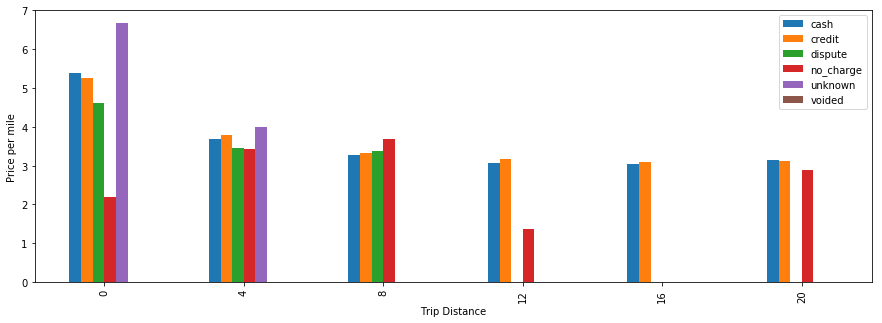

In [5]:
cost_pay.plot.bar(figsize=(15, 5))

#x= np.arange(5)
#y1=np.arange(5)
#y2 = np.ones(5)

#fig = plt.figure()
#ax = fig.add_subplot(111)
#ax.plot(x,y1)
#ax.bar(x,y2)
#plt.show()
#plt_wpl = cost.plot(y='WordPerLine', kind='bar', figsize=(15, 10))
plt.xlabel("Trip Distance")
plt.ylabel("Price per mile")

# Average price per mile of different trip type by trip distance 
We have two trip type, hail and dispatch. We want to explore the price difference between them.

From the result, we can see trip type has a significant effect on trips with less than 4 mile distance. The effect is so dominating. We even write a script to take a look at trips fall into this category. We notice a lot of trips with charge but 0 distance. So we conclude these are trips canceled in the end, but kept driver waiting. It might be the reason of dispatch But more than 4 miles, both have similar fare amount.

In [6]:
cost_trip = pd.DataFrame(columns=['hail', 'dispatch']);
for i in range (0, 24, 4):
    if (i == 20):
        d_dis = data[(data['trip_distance'] >= i)]
    else:
        d_dis = data[(data['trip_distance'] >= i) & (data['trip_distance'] < (i+4))];
    d_hl = d_dis[d_dis['trip_type']==1];
    d_dp = d_dis[d_dis['trip_type']==2];
    av_hl = 0
    av_dp = 0
    if (d_hl.shape[0] > 0):
        av_hl =  d_hl['total_amount'].sum()/d_hl['trip_distance'].sum()
    if (d_dp.shape[0] > 0):
        av_dp =  d_dp['total_amount'].sum()/d_dp['trip_distance'].sum()
    #print(av_cr)
    #print(av_ca)
    #print(av_uk)
    df_add = pd.DataFrame({'hail': av_hl, 'dispatch': av_dp}, index=[i])
    #print(df_add)
    cost_trip = cost_trip.append(df_add)
cost_trip

,dispatch,hail
0,14.590909,6.466786
4,3.755239,4.394801
8,3.345960,3.880031
12,3.731828,3.622900
16,4.205836,3.623921
20,3.165357,3.644872


Text(0,0.5,'Price per mile')

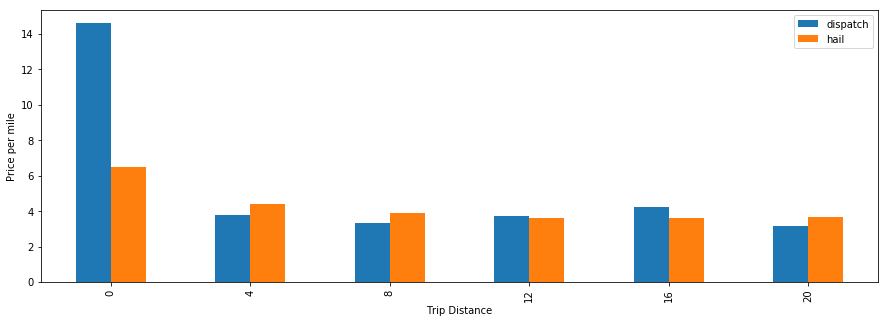

In [7]:
cost_trip.plot.bar(figsize=(15, 5))
plt.xlabel("Trip Distance")
plt.ylabel("Price per mile")

In [8]:
d_check = data[(data['trip_distance'] >= 0) & (data['trip_distance'] < (4))]
d_check = d_check[d_check['trip_type'] ==2]
d_check

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type
36,2,2017-01-01 00:59:20,2017-01-01 01:09:13,N,5,69,169,1,1.34,10.0,0.0,0.0,0.00,0.0,NaN,0.0,10.00,2,2
182,1,2017-01-01 03:04:43,2017-01-01 03:05:23,N,5,226,226,1,0.00,25.0,0.0,0.0,5.00,0.0,NaN,0.0,30.00,1,2
523,2,2017-01-02 11:34:10,2017-01-02 11:51:07,N,5,3,185,1,1.33,7.0,0.0,0.0,0.00,0.0,NaN,0.0,7.00,2,2
754,2,2017-01-03 09:28:34,2017-01-03 09:35:15,N,5,41,74,1,0.94,8.0,0.0,0.0,0.00,0.0,NaN,0.0,8.00,2,2
830,2,2017-01-03 14:37:22,2017-01-03 14:38:37,N,5,225,225,1,0.00,100.0,0.0,0.0,30.00,0.0,NaN,0.0,130.00,1,2
839,1,2017-01-03 14:34:51,2017-01-03 14:35:27,N,5,193,193,1,1.00,0.0,0.0,0.0,0.00,0.0,NaN,0.0,0.00,2,2
842,1,2017-01-03 14:00:22,2017-01-03 14:01:35,N,5,71,71,2,0.00,35.0,0.0,0.0,8.75,0.0,NaN,0.0,43.75,1,2
879,1,2017-01-03 16:59:40,2017-01-03 17:15:18,N,5,244,41,1,2.50,0.0,0.0,0.0,0.00,0.0,NaN,0.0,0.00,2,2
1018,2,2017-01-04 07:47:53,2017-01-04 07:47:54,N,5,3,81,1,0.26,11.0,0.0,0.0,0.00,0.0,NaN,0.0,11.00,1,2
1027,2,2017-01-04 08:29:55,2017-01-04 08:30:06,N,5,92,92,1,0.00,8.0,0.0,0.0,1.60,0.0,NaN,0.0,9.60,1,2


In [9]:
data['hour'] = data.lpep_pickup_datetime.apply(lambda t:t.hour)
data['date_in_week'] = data.lpep_pickup_datetime.apply(lambda t:t.weekday())
data['month'] = data.lpep_pickup_datetime.apply(lambda t:t.month)
data.sample(2)

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,hour,date_in_week,month
44647,1,2017-05-05 23:23:14,2017-05-05 23:34:05,N,1,130,205,1,2.50,10.5,...,0.0,0.0,NaN,0.3,11.8,2,1,23,4,5
113013,2,2017-12-16 13:32:07,2017-12-16 13:41:32,N,1,226,226,1,1.22,8.0,...,0.0,0.0,NaN,0.3,8.8,2,1,13,5,12


# Average trip distance of different month by hours in a day
We want to see the effect of different time of a day on the average trip distance.

The result is very counter intuitive. Around 5am, people travel the longest distance, and around the rush hours, it's actually the lowest.

Text(0,0.5,'Trip Distance')

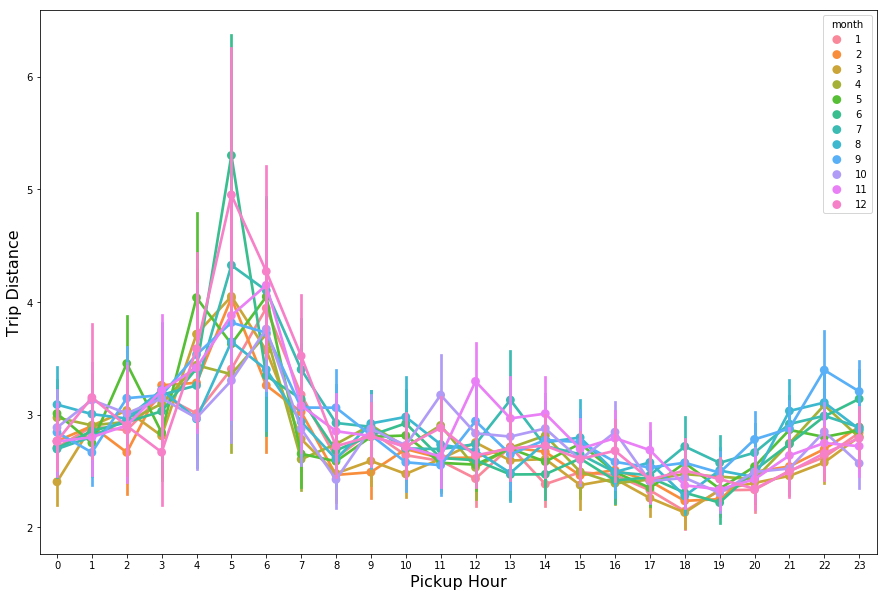

In [15]:
import seaborn as sns
plt.figure(figsize=(15,10))
sns.pointplot(x='hour',y='trip_distance',data=data,kind='point',hue='month')
plt.xlabel('Pickup Hour',fontsize=16)
plt.ylabel('Trip Distance',fontsize=16)

# Count and average price per mile of different hour in a day by trip distance 
To explain, We want to see in details the effect of different time of a day on the number trips and average price per mile.

## Count:
The result is very intuitive. Lowest ride counts happen at 5am, highest point is at 5pm. And since the less than 4 miles trip count is so dominant. We check the line chart for each of the trip distance.

We can see longer distance trips are less affected by hours of the day. This explains the chart above.

## Average price per mile
Highest average price per mile happens around two rush hours of the day

In [10]:
cost_hr = pd.DataFrame(columns=['00','01','02','03','04','05','06','07','08','09','10','11','12','13','14','15','16','17','18','19','20','21','22','23'])
ct_hr = pd.DataFrame(columns=['00','01','02','03','04','05','06','07','08','09','10','11','12','13','14','15','16','17','18','19','20','21','22','23'])
for i in range (0, 24, 4):
    if (i == 20):
        d_dis = data[(data['trip_distance'] >= i)]
    else:
        d_dis = data[(data['trip_distance'] >= i) & (data['trip_distance'] < (i+4))];
    d_00 = d_dis[d_dis['hour']==0];
    d_01 = d_dis[d_dis['hour']==1];
    d_02 = d_dis[d_dis['hour']==2];
    d_03 = d_dis[d_dis['hour']==3];
    d_04 = d_dis[d_dis['hour']==4];
    d_05 = d_dis[d_dis['hour']==5];
    d_06 = d_dis[d_dis['hour']==6];
    d_07 = d_dis[d_dis['hour']==7];
    d_08 = d_dis[d_dis['hour']==8];
    d_09 = d_dis[d_dis['hour']==9];
    d_10 = d_dis[d_dis['hour']==10];
    d_11 = d_dis[d_dis['hour']==11];
    d_12 = d_dis[d_dis['hour']==12];
    d_13 = d_dis[d_dis['hour']==13];
    d_14 = d_dis[d_dis['hour']==14];
    d_15 = d_dis[d_dis['hour']==15];
    d_16 = d_dis[d_dis['hour']==16];
    d_17 = d_dis[d_dis['hour']==17];
    d_18 = d_dis[d_dis['hour']==18];
    d_19 = d_dis[d_dis['hour']==19];
    d_20 = d_dis[d_dis['hour']==20];
    d_21 = d_dis[d_dis['hour']==21];
    d_22 = d_dis[d_dis['hour']==22];
    d_23 = d_dis[d_dis['hour']==23];
    av_00 = 0
    av_01 = 0
    av_02 = 0
    av_03 = 0
    av_04 = 0
    av_05 = 0
    av_06 = 0
    av_07 = 0
    av_08 = 0
    av_09 = 0
    av_10 = 0
    av_11 = 0
    av_12 = 0
    av_13 = 0
    av_14 = 0
    av_15 = 0
    av_16 = 0
    av_17 = 0
    av_18 = 0
    av_19 = 0
    av_20 = 0
    av_21 = 0
    av_22 = 0
    av_23 = 0
    if (d_00.shape[0] > 0):
        av_00 =  d_00['fare_amount'].sum()/d_00['trip_distance'].sum()
    if (d_01.shape[0] > 0):
        av_01 =  d_01['fare_amount'].sum()/d_01['trip_distance'].sum()
    if (d_02.shape[0] > 0):
        av_02 =  d_02['fare_amount'].sum()/d_02['trip_distance'].sum()
    if (d_03.shape[0] > 0):
        av_03 =  d_03['fare_amount'].sum()/d_03['trip_distance'].sum()
    if (d_04.shape[0] > 0):
        av_04 =  d_04['fare_amount'].sum()/d_04['trip_distance'].sum()
    if (d_05.shape[0] > 0):
        av_05 =  d_05['fare_amount'].sum()/d_05['trip_distance'].sum()
    if (d_06.shape[0] > 0):
        av_06 =  d_06['fare_amount'].sum()/d_06['trip_distance'].sum()
    if (d_07.shape[0] > 0):
        av_07 =  d_07['fare_amount'].sum()/d_07['trip_distance'].sum()
    if (d_08.shape[0] > 0):
        av_08 =  d_08['fare_amount'].sum()/d_08['trip_distance'].sum()
    if (d_09.shape[0] > 0):
        av_09 =  d_09['fare_amount'].sum()/d_09['trip_distance'].sum()
    if (d_10.shape[0] > 0):
        av_10 =  d_10['fare_amount'].sum()/d_10['trip_distance'].sum()
    if (d_11.shape[0] > 0):
        av_11 =  d_11['fare_amount'].sum()/d_11['trip_distance'].sum()
    if (d_12.shape[0] > 0):
        av_12 =  d_12['fare_amount'].sum()/d_12['trip_distance'].sum()
    if (d_13.shape[0] > 0):
        av_13 =  d_13['fare_amount'].sum()/d_13['trip_distance'].sum()
    if (d_14.shape[0] > 0):
        av_14 =  d_14['fare_amount'].sum()/d_14['trip_distance'].sum()
    if (d_15.shape[0] > 0):
        av_15 =  d_15['fare_amount'].sum()/d_15['trip_distance'].sum()
    if (d_16.shape[0] > 0):
        av_16 =  d_16['fare_amount'].sum()/d_16['trip_distance'].sum()
    if (d_17.shape[0] > 0):
        av_17 =  d_17['fare_amount'].sum()/d_17['trip_distance'].sum()
    if (d_18.shape[0] > 0):
        av_18 =  d_18['fare_amount'].sum()/d_18['trip_distance'].sum()
    if (d_19.shape[0] > 0):
        av_19 =  d_19['fare_amount'].sum()/d_19['trip_distance'].sum()
    if (d_20.shape[0] > 0):
        av_20 =  d_20['fare_amount'].sum()/d_20['trip_distance'].sum()
    if (d_21.shape[0] > 0):
        av_21 =  d_21['fare_amount'].sum()/d_21['trip_distance'].sum()
    if (d_22.shape[0] > 0):
        av_22 =  d_22['fare_amount'].sum()/d_22['trip_distance'].sum()
    if (d_23.shape[0] > 0):
        av_23 =  d_23['fare_amount'].sum()/d_23['trip_distance'].sum()
    #print(av_cr)
    #print(av_ca)
    #print(av_uk)
    df_add = pd.DataFrame({'00':av_00,'01':av_01,'02':av_02,'03':av_03,'04':av_04,'05':av_05,'06':av_06,'07':av_07,'08':av_08,'09':av_09,'10':av_10,'11':av_11,'12':av_12,'13':av_13,'14':av_14,'15':av_15,'16':av_16,'17':av_17,'18':av_18,'19':av_19,'20':av_20,'21':av_21,'22':av_22,'23':av_23}, index=[i])
    df_add_ct = pd.DataFrame({'00':d_00.shape[0],'01':d_01.shape[0],'02':d_02.shape[0],'03':d_03.shape[0],'04':d_04.shape[0],'05':d_05.shape[0],'06':d_06.shape[0],'07':d_07.shape[0],'08':d_08.shape[0],'09':d_09.shape[0],'10':d_10.shape[0],'11':d_11.shape[0],'12':d_12.shape[0],'13':d_13.shape[0],'14':d_14.shape[0],'15':d_15.shape[0],'16':d_16.shape[0],'17':d_17.shape[0],'18':d_18.shape[0],'19':d_19.shape[0],'20':d_20.shape[0],'21':d_21.shape[0],'22':d_22.shape[0],'23':d_23.shape[0]}, index=[i])
    #print(df_add)
    cost_hr = cost_hr.append(df_add)
    ct_hr = ct_hr.append(df_add_ct)
cost_hr.sample(2)

,00,01,02,03,04,05,06,07,08,09,...,14,15,16,17,18,19,20,21,22,23
12,2.972473,2.966652,2.925553,2.918476,3.040590,2.957483,3.114677,3.137878,3.088097,2.983731,...,3.173567,3.446372,3.289889,3.420366,3.198029,3.220903,3.070646,3.036842,3.117490,3.096094
4,3.509211,3.460161,3.449136,3.499156,3.382059,3.359290,3.458848,3.669565,3.897073,3.840123,...,3.871420,4.038575,4.164224,4.062393,3.906635,3.719588,3.646742,3.606266,3.590365,3.538604


In [11]:
cost_hr = cost_hr.transpose()
cost_hr

,0,4,8,12,16,20
00,4.855308,3.509211,3.128512,2.972473,3.257129,2.936499
01,4.811565,3.460161,3.134426,2.966652,3.112747,4.161081
02,4.874041,3.449136,3.074373,2.925553,2.905890,3.588752
03,4.947592,3.499156,3.066116,2.918476,2.749775,2.678966
04,4.938933,3.382059,2.941414,3.040590,2.885132,2.755140
05,5.021294,3.359290,3.104934,2.957483,3.097491,2.981767
06,4.912722,3.458848,3.096659,3.114677,2.874250,3.045666
07,5.219873,3.669565,3.304859,3.137878,3.058000,2.767257
08,5.577176,3.897073,3.409303,3.088097,2.861591,3.276560
09,5.490560,3.840123,3.336044,2.983731,2.960717,3.150308


In [12]:
ct_hr = ct_hr.transpose()
ct_hr.sample(2)

,0,4,8,12,16,20
22,4820,964,265,78,19,14
00,3555,721,173,46,9,8


Text(0,0.5,'Trip count')

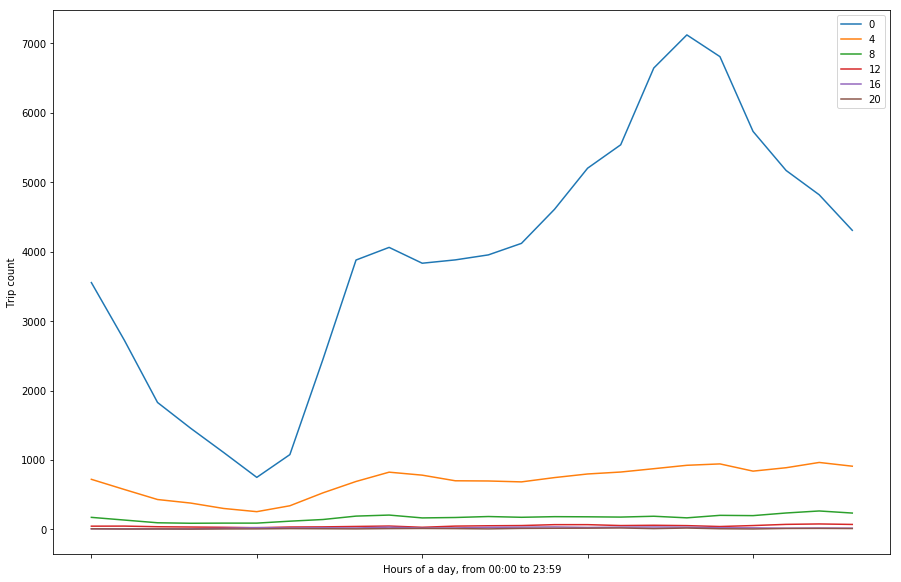

In [14]:
ct_hr.plot.line(figsize=(15, 10))
plt.xlabel("Hours of a day, from 00:00 to 23:59")
plt.ylabel("Trip count")

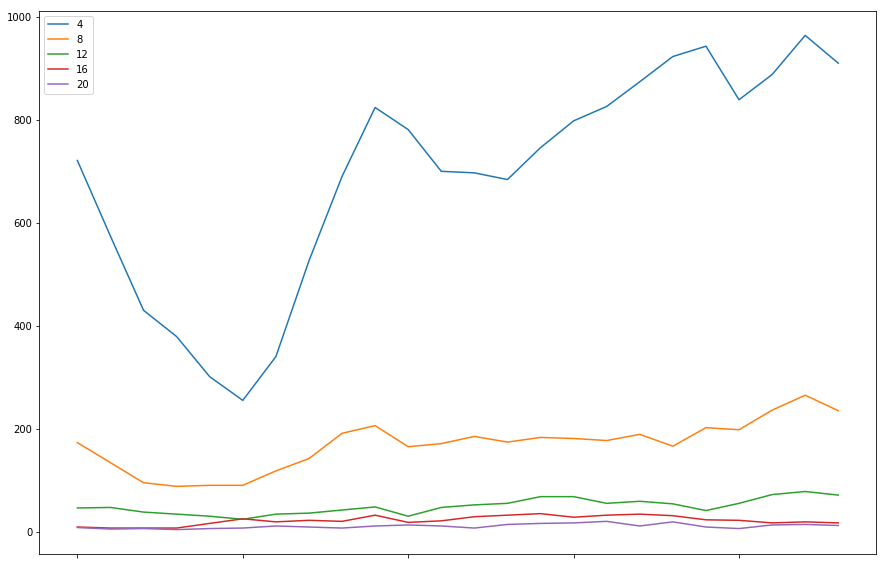

In [16]:
#ct_hr
del ct_hr[0]
ct_hr.plot.line(figsize=(15, 10))

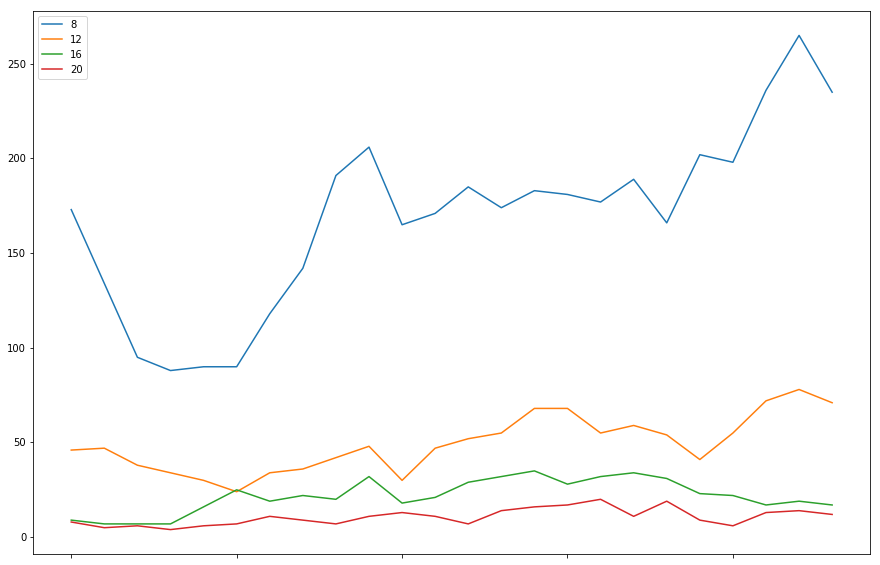

In [17]:
del ct_hr[4]
ct_hr.plot.line(figsize=(15, 10))

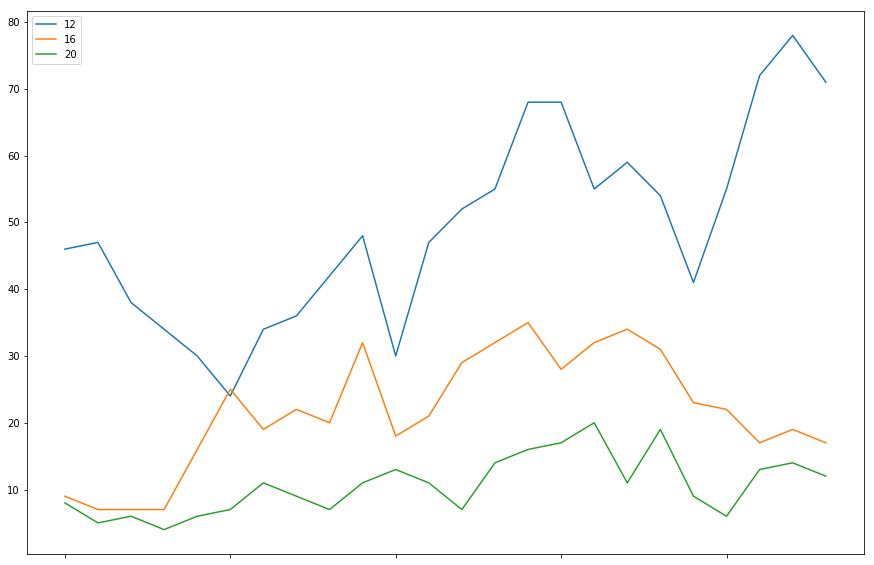

In [18]:
del ct_hr[8]
ct_hr.plot.line(figsize=(15, 10))

Text(0,0.5,'Average price per mile')

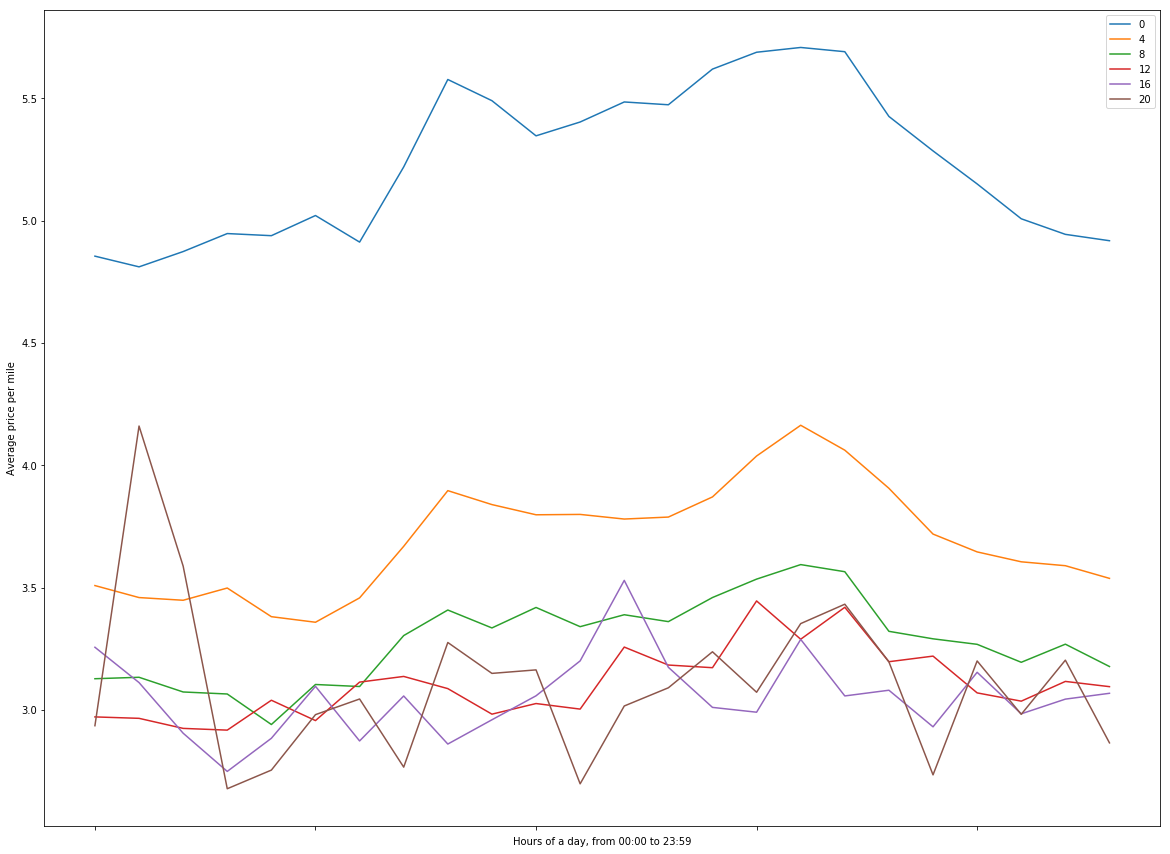

In [20]:
cost_hr.plot.line(figsize=(20, 15))
plt.xlabel("Hours of a day, from 00:00 to 23:59")
plt.ylabel("Average price per mile")

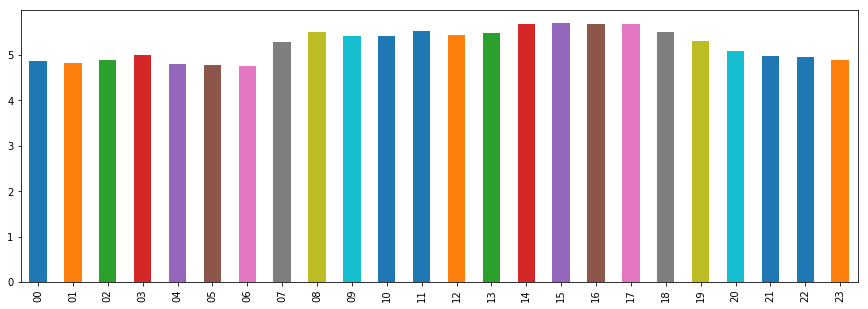

In [14]:
cost_hr.loc[0].plot.bar(figsize=(15, 5))

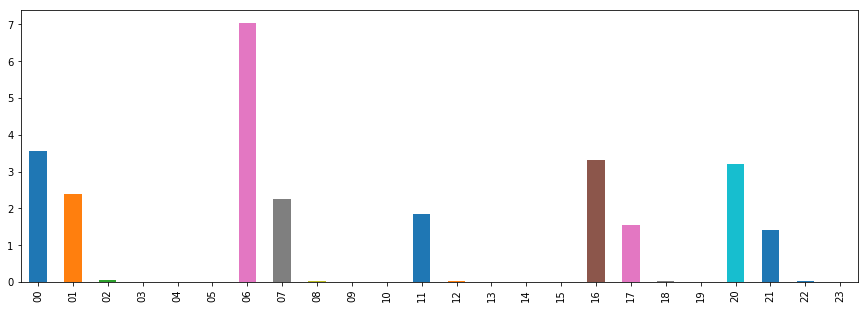

In [42]:
cost_hr.loc[4].plot.bar(figsize=(15, 5))

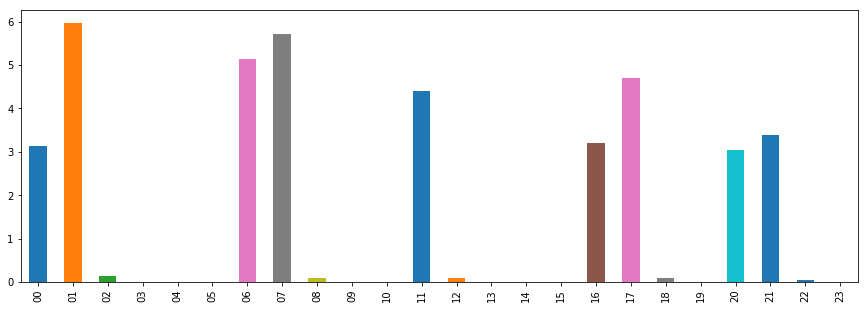

In [43]:
cost_hr.loc[8].plot.bar(figsize=(15, 5))

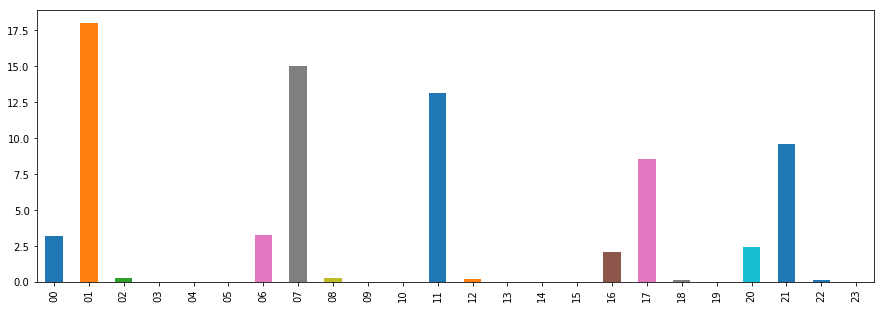

In [44]:
cost_hr.loc[12].plot.bar(figsize=(15, 5))

In [64]:
cost_diw = pd.DataFrame(columns=['0','1','2','3','4','5','6'])
for i in range (0, 24, 4):
    if (i == 20):
        d_dis = data[(data['trip_distance'] >= i)]
    else:
        d_dis = data[(data['trip_distance'] >= i) & (data['trip_distance'] < (i+4))];
    d_0 = d_dis[d_dis['date_in_week']==0];
    d_1 = d_dis[d_dis['date_in_week']==1];
    d_2 = d_dis[d_dis['date_in_week']==2];
    d_3 = d_dis[d_dis['date_in_week']==3];
    d_4 = d_dis[d_dis['date_in_week']==4];
    d_5 = d_dis[d_dis['date_in_week']==5];
    d_6 = d_dis[d_dis['date_in_week']==6];
    av_0 = 0
    av_1 = 0
    av_2 = 0
    av_3 = 0
    av_4 = 0
    av_5 = 0
    av_6 = 0
    if (d_0.shape[0] > 0):
        av_0 =  d_0['fare_amount'].sum()/d_0['trip_distance'].sum()
    if (d_1.shape[0] > 0):
        av_1 =  d_1['fare_amount'].sum()/d_1['trip_distance'].sum()
    if (d_2.shape[0] > 0):
        av_2 =  d_2['fare_amount'].sum()/d_2['trip_distance'].sum()
    if (d_3.shape[0] > 0):
        av_3 =  d_3['fare_amount'].sum()/d_3['trip_distance'].sum()
    if (d_4.shape[0] > 0):
        av_4 =  d_4['fare_amount'].sum()/d_4['trip_distance'].sum()
    if (d_5.shape[0] > 0):
        av_5 =  d_5['fare_amount'].sum()/d_5['trip_distance'].sum()
    if (d_6.shape[0] > 0):
        av_6 =  d_6['fare_amount'].sum()/d_6['trip_distance'].sum()
    df_add = pd.DataFrame({'0':av_0,'1':av_1,'2':av_2,'3':av_3,'4':av_4,'5':av_5,'6':av_6}, index=[i])
    #print(df_add)
    cost_diw = cost_diw.append(df_add)
#cost_diw = cost_diw.transpose()
cost_diw

,0,1,2,3,4,5,6
0,5.299652,5.349704,5.430777,5.460141,5.456637,5.200867,5.037463
4,3.705681,3.761875,3.784970,3.856762,3.821510,3.682264,3.584018
8,3.245092,3.304043,3.350334,3.401149,3.393398,3.279456,3.194101
12,3.188037,3.132937,3.212051,3.169616,3.212973,3.058755,3.088757
16,2.974482,2.952497,2.946028,2.991891,3.023491,3.110382,2.923191
20,3.119631,3.012013,3.160545,2.827807,2.978640,2.927266,3.026124


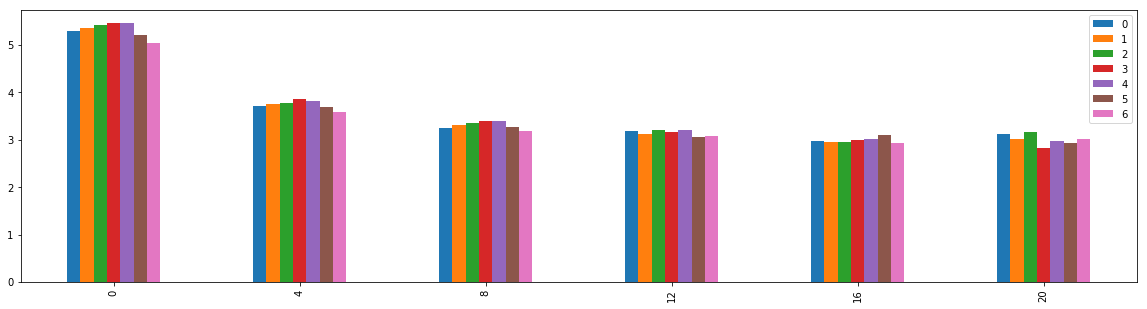

In [65]:
cost_diw.plot.bar(figsize=(20, 5))

In [29]:
data[data['RatecodeID'] == 6]

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,hour,date_in_week,month
39546,1,2017-04-20 23:16:47,2017-04-20 23:17:25,N,6,119,247,1,0.2,2.5,...,0.0,0.0,NaN,0.3,3.3,4,1,23,3,4
